
Classification Report For Random Forest:
              precision    recall  f1-score   support

      Benign       0.99      0.97      0.98        75
   Malignant       0.95      0.97      0.96        39

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Classification Report For ANN:
              precision    recall  f1-score   support

      Benign       0.96      0.94      0.95        72
   Malignant       0.91      0.93      0.92        42

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



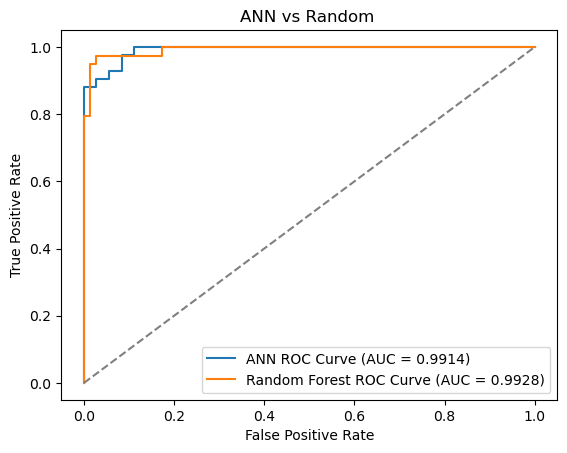

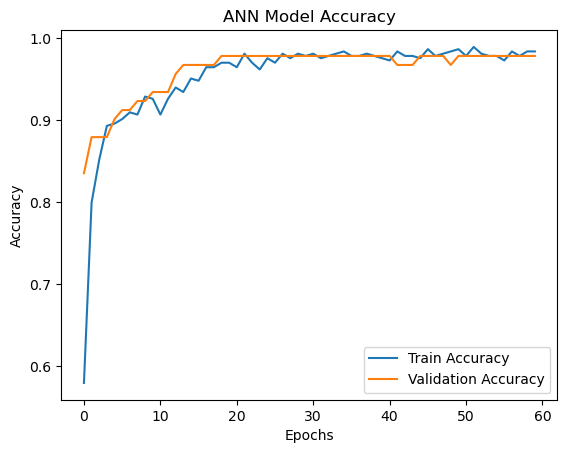

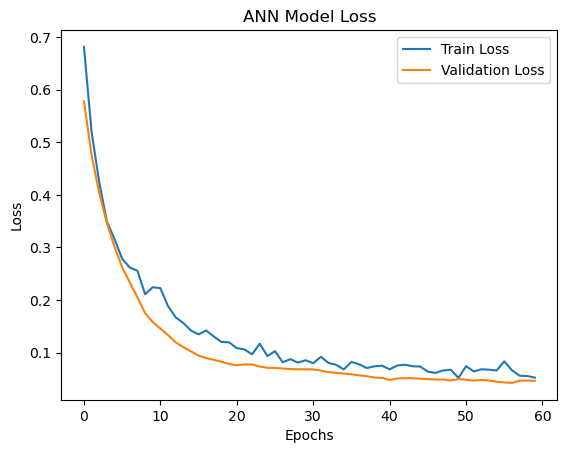

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

data = pd.read_csv('breastcancer.csv') 

features_selected = ['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 
                     'concavity_mean', 'symmetry_mean', 'radius_se', 'concave points_se', 
                     'smoothness_worst', 'compactness_worst', 'concavity_worst', 
                     'symmetry_worst', 'fractal_dimension_worst'] # Features that were highly correlated when feature selection was done


X1 = data[features_selected]
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})  # Convert labels to binary
y1 = data['diagnosis']


X1 = X1.dropna()
y1 = y1.dropna()

X1 = X1.loc[y1.index] # make sure X & y line up together

#train test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=23)

#define classifier with best parameters
best_rf = RandomForestClassifier(
    bootstrap=False,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100,
    random_state=23
)

# Fit the model
best_rf.fit(X_train1, y_train1)

# Predict and evaluate the model
y_pred_best_rf = best_rf.predict(X_test1)

#metrics for Random Forest
y_pred_probs_rf = best_rf.predict_proba(X_test1)[:,1]
roc_auc_rf = roc_auc_score(y_test1, y_pred_probs_rf)

#gives accuracy precision F1 of pred vs test
print("\nClassification Report For Random Forest:")
print(classification_report(y_test1, y_pred_best_rf, target_names=["Benign", "Malignant"]))

#roc and auc
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test1, y_pred_probs_rf)
######################################################-ANN-############################################################
X2 = data[features_selected]
y2 = data['diagnosis']

# training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=23, stratify=y2)

# scaler
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

# ANN architechture
def create_model(learning_rate=0.001, dropout_rate=0.3):
    model = Sequential([
        Input(shape=(X_train2.shape[1],)),  # Input layer
        Dense(64, activation='relu'),     # First hidden layer
        Dropout(dropout_rate),            # Dropout for regularization
        Dense(32, activation='relu'),     # Second hidden layer
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')    # Output layer for binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# initial lr and training 
learning_rate = 0.001
dropout_rate = 0.3
model = create_model(learning_rate=learning_rate, dropout_rate=dropout_rate)

history = model.fit(
    X_train2, y_train2,
    epochs=60,           
    batch_size=32,       
    validation_split=0.2,     
    verbose=0
)
# metrics 
y_pred_probs_ANN = model.predict(X_test2).flatten()  
y_pred_ANN = (y_pred_probs_ANN > 0.5).astype(int)  
fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(y_test2, y_pred_probs_ANN)
print("\nClassification Report For ANN:")
print(classification_report(y_test2, y_pred_ANN, target_names=["Benign", "Malignant"]))
# AUC-ROC
roc_auc_ANN = roc_auc_score(y_test2, y_pred_probs_ANN)

#plot ROC with AUC
plt.figure()
plt.plot(fpr_ANN, tpr_ANN, label=f"ANN ROC Curve (AUC = {roc_auc_ANN:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest ROC Curve (AUC = {roc_auc_rf:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ANN vs Random ")
plt.legend()
plt.show()

# plot ANN accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot ANN loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()